In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn

#For Optuna (Hyperparameters search)
import optuna
from optuna.integration import PyTorchLightningPruningCallback

#Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns



import torch.nn.functional as F


import model

C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set seeds for reproducibility (PyTorch, Python, Numpy)
matricola = 2013031
torch.manual_seed(matricola)
random.seed(matricola)
np.random.seed(matricola)

# Import the data

In [3]:
### Download the data and create dataset
data_dir = '../dataset'
# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=False)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=False)

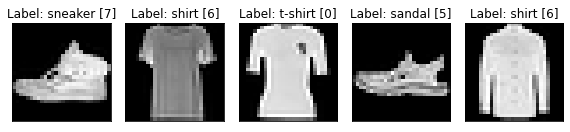

In [4]:
### Plot some sample
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
fig, axs = plt.subplots(1, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title(f'Label: {label_names[label]} [{label}]')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [5]:
# In this case the train_transform and test_transform are the same, 
# but we keep them separate for potential future updates
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [6]:
### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)


batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


# Implement autoencoder

In [7]:
encoded_space_dim = 2

In [8]:
# Initialize the autoencoder
AE = model.Autoencoder(encoded_space_dim)

In [9]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [
    {'params': AE.encoder.parameters()},
    {'params': AE.decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=0.0067, weight_decay=1.7e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cpu


EPOCH 1/50
AVERAGE TRAIN LOSS: 0.05966539680957794
AVERAGE TEST LOSS: 0.0377078577876091


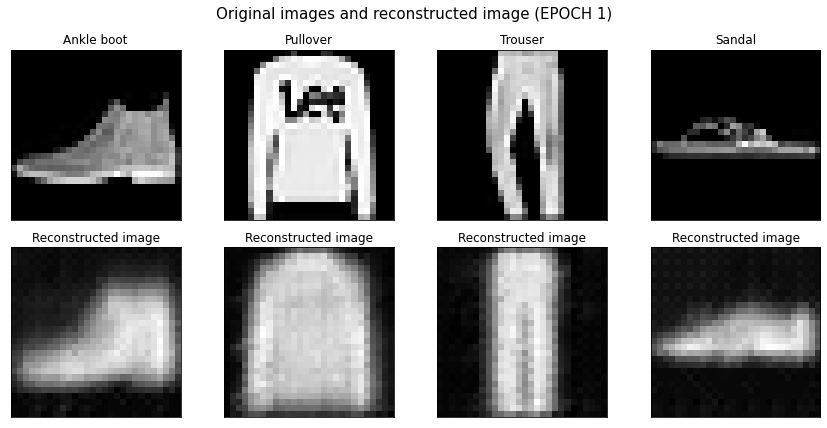

EPOCH 2/50
AVERAGE TRAIN LOSS: 0.03600972518324852
AVERAGE TEST LOSS: 0.03514765948057175
EPOCH 3/50
AVERAGE TRAIN LOSS: 0.04153183847665787
AVERAGE TEST LOSS: 0.03389059379696846
EPOCH 4/50
AVERAGE TRAIN LOSS: 0.0330754779279232
AVERAGE TEST LOSS: 0.03259352222084999
EPOCH 5/50
AVERAGE TRAIN LOSS: 0.031954843550920486
AVERAGE TEST LOSS: 0.031704965978860855
EPOCH 6/50


In [ ]:
train, test = AE.training_cycle(AE.encoder,
                                AE.decoder,
                                device,
                                train_dataloader,
                                test_dataloader,
                                loss_fn,
                                optim,
                                50,
                                test_dataset,
                                plot = True)

In [ ]:
# Plot losses by epoch
plt.figure(figsize=(7,5))
plt.semilogy(train, linestyle='--', marker='o', color='r', label='Train loss')
plt.semilogy(test, linestyle='--', marker='o', color='g', label='Test loss')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.title("Losses",fontsize=15)
plt.grid()
plt.legend()
#plt.savefig('./imgs/classification/losses.svg', format='svg')
plt.show()

# Optimize autoencoder parameters

In [ ]:
def objective(trial):
    max_epochs = 5
    
    # Parameters for the search
    encoded_space_dim      = trial.suggest_categorical("encoded_space_dim", [2,10])
    optimizer_name         = trial.suggest_categorical('optimizer_name',["SGD", "Adam"])
    lr                     = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    
    
    
    ### Initialize both networks
    encoder = Encoder(encoded_space_dim=encoded_space_dim)
    decoder = Decoder(encoded_space_dim=encoded_space_dim)
    
    ### Define the complete model
    model = nn.Sequential(encoder, decoder)
    model = model.to(device)
    
    
    ### Define the loss function
    loss_fn = torch.nn.MSELoss()
    
    
    #Define the optimizer
    optimizer = getattr(torch.optim,optimizer_name)(model.parameters(), lr=lr)

    ################################################################################################
    # Train a model (cant use the function because I would need the separated parts encoder decoder)
    for epoch in range(max_epochs):
        print('EPOCH %d/%d' % (epoch + 1, max_epochs))
        ### Training (use the training function)
        # Set train mode for both networks
        model.train()  
        train_loss = []
        
        # Train
        for sample_batched, _ in train_dataloader:
            # Move data to device
            sample_batched = sample_batched.to(device)
            # Encode decode the data
            encoded_decoded_sample = model(sample_batched)
            loss = loss_fn(encoded_decoded_sample, sample_batched)
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            #Updata weights
            optimizer.step()
            #Save trai loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)
        #Save the average train loss
        train_loss = np.mean(train_loss)
        print(f"AVERAGE TRAIN LOSS: {train_loss}")
   
        ### Validation  (use the testing function)
        # Set evaluation mode for both networks
        model.eval()
        test_loss = []
        # Discable gradient tracking
        with torch.no_grad():
            for sample_batched, _ in test_dataloader:
                # Move data to device
                sample_batched = sample_batched.to(device)
                # Encode decode the data
                encoded_decoded_sample = model(sample_batched)
                # Compute loss
                loss = loss_fn(encoded_decoded_sample, sample_batched)
                 #Save test loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                test_loss.append(loss_batch)
            #Save the average train loss
            test_loss = np.mean(test_loss)
            print(f"AVERAGE TEST LOSS: {test_loss}")    
    
    
    return test_loss

In [ ]:
#Define the study
study = optuna.create_study(study_name="myfirstoptimizationstudy", direction="minimize")
study.optimize(objective, n_trials=10, timeout=30) #six hours

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_contour(study, params=['lr','encoded_space_dim'])

## Re train best model 

In [ ]:
AE = model.Autoencoder(2)

In [ ]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [
    {'params': AE.encoder.parameters()},
    {'params': AE.decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=0.0067, weight_decay=1.7e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

In [ ]:
train, test = AE.training_cycle(AE.encoder,AE.decoder,device,train_dataloader, test_dataloader, loss_fn, optim,5,test_dataset,plot = True)

In [ ]:
# Plot losses by epoch
plt.figure(figsize=(7,5))
plt.semilogy(train, linestyle='--', marker='o', color='r', label='Train loss')
plt.semilogy(test, linestyle='--', marker='o', color='g', label='Test loss')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.title("Losses",fontsize=15)
plt.grid()
plt.legend()
#plt.savefig('./imgs/classification/losses.svg', format='svg')
plt.show()

# Latent space exploration

## If encoding dimension is 2

In [ ]:
# Load network parameters
AE.encoder.load_state_dict(torch.load('encoder_params.pth'))
AE.decoder.load_state_dict(torch.load('decoder_params.pth'))

In [ ]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    AE.encoder.eval()
    with torch.no_grad():
        encoded_img  = AE.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

In [ ]:
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

In [ ]:
import plotly.express as px
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)

## PCA

## TSNE

# Convolutional autoencoder fine tuning

## Data

In [ ]:
#Define a validation dataset
train_percent = 0.7
n_train      = int(train_percent * len(train_dataset))
n_validation = len(train_dataset) - n_train
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [n_train, n_validation])

print('# of training samples  :',len(train_dataset))
print('# of validation samples:',len(val_dataset))
print('# of test samples      :',len(test_dataset))


In [ ]:
batch_size = 256
train_dataloader      = DataLoader(train_dataset,  batch_size=batch_size,        shuffle=True, num_workers=0)
validation_dataloader = DataLoader(val_dataset,    batch_size=len(val_dataset),  shuffle=False, num_workers=0)
test_dataloader       = DataLoader(test_dataset,   batch_size=len(test_dataset), shuffle=False, num_workers=0)


## Transfer the autoencoder encoder weights to the supervised network

In [ ]:
encoded_space_dim = 2

In [ ]:
# Initialize the old autoencoder
AE = model.Autoencoder(encoded_space_dim)
# Load network parameters
AE.encoder.load_state_dict(torch.load('encoder_params.pth'))

In [ ]:
#Initialize the Autoencoder for fine tuning
FTAE = model.Fine_Tuned_Autoencoder(encoded_space_dim,AE)


In [ ]:
FTAE

In [ ]:
### Disable the weight update for the trained encoder
for param_name, param in FTAE.encoder.named_parameters():
    param.requires_grad = False

### Allow weight update (training) of the last layers (linear layers)
for param in FTAE.encoder[7].parameters():
    param.requires_grad = True
    
### Allow weight update (training) of the last layers (linear layers)
for param in FTAE.encoder[9].parameters():
    param.requires_grad = True

### Check which weights and biases will be updated
for param_name, param in FTAE.encoder.named_parameters():
    print(param_name,param.requires_grad)

In [ ]:
### Define the loss function
loss_fn = nn.CrossEntropyLoss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [
    {'params': FTAE.encoder.parameters()},
    {'params': FTAE.new_layer.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=1e-3, weight_decay=0.)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

In [ ]:
train, test = FTAE.tune_training_cycle(FTAE.encoder,
                                       FTAE.new_layer,
                                       device,
                                       train_dataloader,
                                       validation_dataloader,
                                       loss_fn,
                                       optim,
                                       20,
                                       test_dataloader)

In [ ]:
# Plot losses by epoch
plt.figure(figsize=(7,5))
plt.semilogy(train, linestyle='--', marker='o', color='r', label='Train loss')
plt.semilogy(test, linestyle='--', marker='o', color='g', label='Test loss')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.title("Losses",fontsize=15)
plt.grid()
plt.legend()
#plt.ylim(0,2)
#plt.savefig('./imgs/classification/losses.svg', format='svg')
plt.show()

In [ ]:
test_acc = 0

y_test=[]
y_pred=[]

FTAE.encoder.to(device)
#move the input to the GPU and predict the output
FTAE.encoder.eval()
FTAE.new_layer.eval()

with torch.no_grad():
    for x_batched, y_batched in test_dataloader:
        # Move data to device
        x_batched = x_batched.to(device)
        y_batched = y_batched.to(device)

        # Encode the data
        z   = FTAE.encoder(x_batched)
        out = FTAE.new_layer(z)

        y_test.append(y_batched)
        y_pred.append(out)

        pred = np.argmax(out.detach().cpu().numpy(), axis = 1)
        right = np.sum(pred == np.array(y_batched.cpu()))
        test_acc = test_acc + right

print(f"The obtained accuracy is {test_acc/len(test_dataset)*100} %")

In [ ]:
def confussion_plot(real, prediction):
    categories = ['T-shirt/top','Trouser','Pullover',
                    'Dress','Coat','Sandal','Shirt',
                    'Sneaker','Bag','Ankle boot']

    array = confusion_matrix(real, prediction,normalize="true")
    df_cm = pd.DataFrame(array, index = categories, columns = categories)
    
    fig = plt.figure(figsize=(8,7))
    sns.heatmap(df_cm, annot=True, fmt='.2f')
    plt.ylabel("Correct",fontsize=15)
    plt.xlabel("Predicted",fontsize=15)
    plt.title("Confussion matrix",fontsize=15)
    #plt.savefig('./imgs/classification/confussion.svg', format='svg')
    plt.show()

In [ ]:
confussion_plot(y_batched, pred)